# Clustering based on BYTES, PACKETS, DURATION

## Preparing a dataset

Load the dataset.

In [99]:
from cesnet_datazoo.datasets import CESNET_QUIC22

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS")

Prepare the dataset with config and see its columns.

In [100]:
from cesnet_datazoo.config import DatasetConfig

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=100_000,
    use_packet_histograms=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)
data_df = dataset.get_train_df()
data_df.columns

Loading data from dataloader


100%|██████████| 521/521 [00:21<00:00, 24.35it/s] 


Index(['PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

Get only the columns that are needed for clustering.

In [101]:
import numpy as np

features_array = data_df[["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION"]].to_numpy()
correct_clusters_array = data_df[["APP"]].to_numpy()

## Analysis

Discover statistics of the dataset.

In [102]:
data_df[["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION"]].describe()

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION
count,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000
mean,44.652401,150.649124,1.639926e+04,1.692565e+05,9.468164
std,625.932251,2088.789551,6.880626e+05,2.635584e+06,29.606266
min,1.000000,1.000000,1.228000e+03,5.900000e+01,0.000175
25%,8.000000,9.000000,2.730000e+03,3.244000e+03,0.094604
50%,12.000000,13.000000,4.178500e+03,5.257000e+03,0.218190
75%,22.000000,24.000000,7.168000e+03,1.051200e+04,4.976531
max,162848.000000,489305.000000,2.060549e+08,6.242670e+08,356.115967


See the head of the dataset.

In [103]:
data_df[["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION", "APP"]].head()

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,APP
0,17.0,14.0,6040.0,9644.0,0.516582,31
1,12.0,15.0,4577.0,2998.0,1.469174,32
2,5.0,7.0,2692.0,7346.0,0.086534,22
3,84.0,122.0,9732.0,86583.0,26.039257,100
4,5.0,6.0,2012.0,2439.0,0.093410,91


## Preprocessing

Define a pipeline for preprocessing.

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

## Clustering

Define function for DBSCAN clustering.

In [105]:
from sklearn.cluster import DBSCAN, HDBSCAN

def dbscan_clustering(data, eps=0.1, min_samples=5):
    return DBSCAN(eps=eps, min_samples=min_samples).fit(data)

def hdbscan_clustering(data, min_cluster_size=5):
    return HDBSCAN(min_cluster_size=min_cluster_size).fit(data)

Perform DBSCAN clustering.

In [106]:
model = hdbscan_clustering(preprocessed_array)
labels = model.labels_[:]

## Postprocessing

Remove outliers.

In [107]:
import numpy as np

outliers = np.where(model.labels_ == -1)
# no_outliers_array = np.delete(preprocessed_array, outliers, axis=0)
# no_outliers_clusters_app = np.delete(correct_clusters_array, outliers)
# no_outliers_labels = np.delete(model.labels_, outliers)

print(f"Number of outliers: {len(outliers[0])}")

Number of outliers: 39612


## Evaluation

### Homogeneity, completeness and V-measure

In [108]:
from sklearn.metrics import homogeneity_completeness_v_measure

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(correct_clusters_array.reshape(-1), labels)
f"Homogeneity (each cluster contains only members of a single class): {homogeneity}", f"Completeness (all members of a given class are assigned to the same cluster): {completeness}", f"V-measure: {v_measure}"

('Homogeneity (each cluster contains only members of a single class): 0.3493566549869013',
 'Completeness (all members of a given class are assigned to the same cluster): 0.2234320307346452',
 'V-measure: 0.2725524048229289')

### Fowlkes-Mallows index

In [109]:
from sklearn.metrics import fowlkes_mallows_score

"FM index:", fowlkes_mallows_score(labels, correct_clusters_array.reshape(-1))

('FM index:', 0.08090155639567403)

### Pair matrix

In [110]:
from sklearn.metrics import pair_confusion_matrix

matrix = pair_confusion_matrix(correct_clusters_array.reshape(-1), labels)
f"In true labelling: together, but in predicted: not  {matrix[1, 0]}", f"In true labelling: not together, but in predicted: together  {matrix[0, 1]}"

('In true labelling: together, but in predicted: not  319531168',
 'In true labelling: not together, but in predicted: together  1507946088')

## Visualization

Define function for visualization.

In [111]:
import matplotlib.pyplot as plt

def plot_clusters(data, label, axis=True):
    plt.figure(figsize=(10, 10))
    plt.scatter(data[:, 0], data[:, 1], c=label)
    
    plt.axis(axis)

    plt.show()

Visualize the clusters.

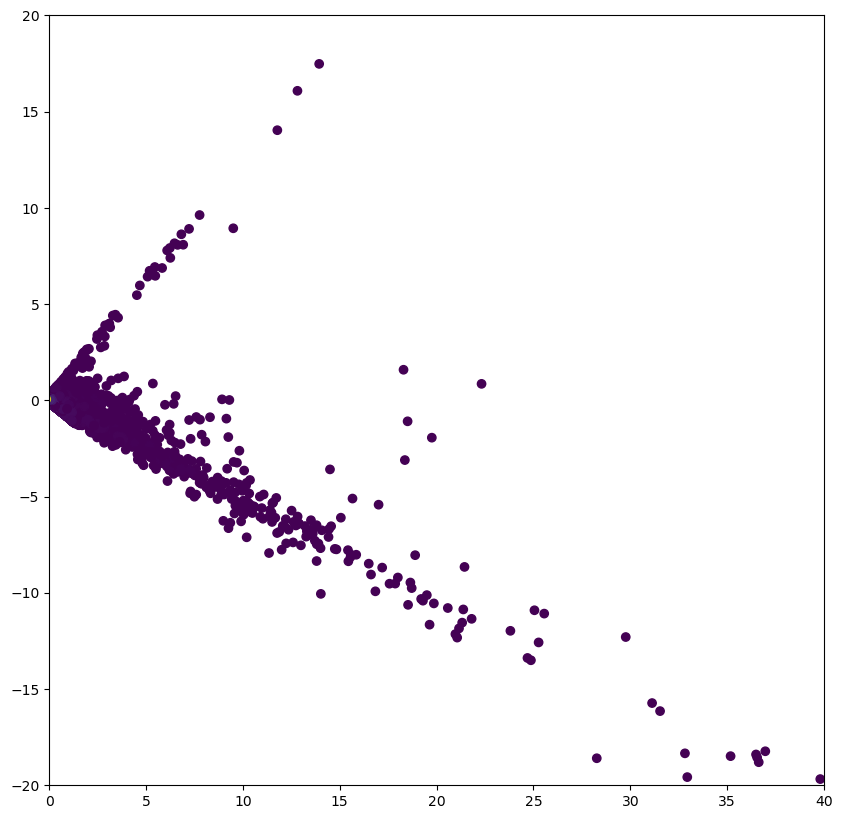

In [112]:
plot_clusters(preprocessed_array, labels, [0, 40, -20, 20])